## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [2]:
path = kagglehub.dataset_download("xfkzujqjvx97n/football-datasets")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Minmin.Yuan\.cache\kagglehub\datasets\xfkzujqjvx97n\football-datasets\versions\2


In [3]:
print(os.listdir(path))

['player_injuries', 'player_latest_market_value', 'player_market_value', 'player_national_performances', 'player_performances', 'player_profiles', 'player_teammates_played_with', 'team_children', 'team_competitions_seasons', 'team_details', 'transfer_history']


### Load Relevant Tables

In [4]:
injuries_file = os.path.join(path, "player_injuries", "player_injuries.csv")
performance_file = os.path.join(path,"player_performances","player_performances.csv")
profile_file = os.path.join(path, "player_profiles","player_profiles.csv")

In [5]:
injuries = pd.read_csv(injuries_file)
print(injuries.head(5))

   player_id season_name     injury_reason   from_date    end_date  \
0         10       15/16       Hand injury  2016-04-19  2016-04-29   
1         10       15/16    Thigh problems  2015-12-18  2015-12-31   
2         10       15/16   Capsular injury  2015-11-11  2015-11-21   
3         10       15/16              Rest  2015-11-04  2015-11-06   
4         10       15/16  Hamstring injury  2015-08-20  2015-10-08   

   days_missed  games_missed  
0         11.0             2  
1         14.0             1  
2         11.0             0  
3          3.0             1  
4         50.0            10  


In [9]:
performance = pd.read_csv(performance_file)
print(performance.head(5))

   player_id season_name competition_id   competition_name  team_id  \
0          1       08/09           OBLG  NOFV-Oberliga Süd     4825   
1          1       07/08             RS   Regionalliga Süd     1526   
2          1       06/07             L2      2. Bundesliga      996   
3          1       06/07            DFB          DFB-Pokal      996   
4          1       05/06             L2      2. Bundesliga       66   

                     team_name  nb_in_group  nb_on_pitch  goals  assists  \
0                 FC Eilenburg            9            9    0.0        0   
1  FSV Ludwigshafen Oggersheim           22           22    1.0        0   
2                  TuS Koblenz           10            4    0.0        0   
3                  TuS Koblenz            1            0    0.0        0   
4           SpVgg Unterhaching           26           14    1.0        1   

   own_goals  subed_in  subed_out  yellow_cards  second_yellow_cards  \
0          0         0          2           

In [27]:
profile = pd.read_csv(profile_file)
print(profile.head(5))

   player_id     player_slug             player_name  \
0          1    silvio-adzic        Silvio Adzic (1)   
1     100011   everton-silva  Éverton Silva (100011)   
2         10  miroslav-klose     Miroslav Klose (10)   
3      10001   john-thompson   John Thompson (10001)   
4     100001   carlos-auzqui  Carlos Auzqui (100001)   

                                    player_image_url  \
0  https://img.a.transfermarkt.technology/portrai...   
1  https://img.a.transfermarkt.technology/portrai...   
2  https://img.a.transfermarkt.technology/portrai...   
3  https://img.a.transfermarkt.technology/portrai...   
4  https://img.a.transfermarkt.technology/portrai...   

            name_in_home_country date_of_birth      place_of_birth  \
0                            NaN    1980-09-23           Grünstadt   
1  Éverton José Modesto da Silva    1988-08-04  São João de Meriti   
2           Miroslav Josef Klose    1978-06-09               Opole   
3             John Paul Thompson    1981-10-12

C:\Users\Minmin.Yuan\AppData\Local\Temp\ipykernel_41732\555434735.py:1: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  profile = pd.read_csv(profile_file)


### Clean Data Format

In [8]:
injuries.describe()

,player_id,days_missed,games_missed
count,1.431950e+05,143173.000000,143195.000000
mean,2.531593e+05,51.719291,6.628479
std,2.318766e+05,104.437179,9.468380
min,2.000000e+00,1.000000,0.000000
25%,6.168200e+04,10.000000,1.000000
50%,1.888540e+05,22.000000,3.000000
75%,3.817940e+05,53.000000,7.000000
max,1.396965e+06,8655.000000,208.000000


In [11]:
injuries= injuries[injuries["days_missed"]<=365] #remove outliers

#### Unify season id

In [13]:
print(injuries.groupby("season_name")["season_name"].count()) #season_name has inconsistent formats

season_name
00/01        215
01/02        248
02/03        251
03/04        277
04/05        345
05/06        329
06/07        388
07/08       1365
08/09       1977
09/10       1758
10/11       2393
11/12       2791
12/13       3377
13/14       4106
14/15       4638
15/16       5759
16/17       7515
17/18       8653
18/19      10362
19/20      10234
1909/10        5
1910/11        2
20/21      13944
21/22      14763
22/23      14133
23/24      14254
24/25      15012
25/26       2103
73/74          2
74/75          3
75/76          2
80/81          3
81/82          1
82/83          1
83/84          3
89/90          5
90/91          3
91/92          5
92/93          5
93/94         22
94/95         23
95/96         46
96/97         65
97/98         81
98/99        122
99/00        157
Name: season_name, dtype: int64


In [14]:
print(performance["season_name"].value_counts())  #season_name has inconsistent formats

season_name
22/23    106476
23/24    105401
21/22    104402
24/25    103828
20/21     89959
          ...  
65/66         1
1960          1
61/62         1
60/61         1
1984          1
Name: count, Length: 102, dtype: int64


In [15]:
import re

def _two_digit_to_year(two: int, pivot: int = 49) -> int:
    """
    Map a 2-digit year to a full year using a pivot:
    - two <= pivot -> 2000s (e.g., 25 -> 2025)
    - two > pivot  -> 1900s (e.g., 73 -> 1973)
    Default pivot=49 covers modern football datasets well.
    """
    return 2000 + two if two <= pivot else 1900 + two

def season_name_to_start_year(season_str: str) -> int:
    """
    Return the START YEAR for a season string.

    Supported formats:
      - 'YY/YY'       -> e.g., '22/23' -> 2022
      - 'YYYY/YY'     -> e.g., '1909/10' -> 1909 (rollover handled)
      - 'YY/YYYY'     -> e.g., '99/2000' -> 1999
      - 'YYYY/YYYY'   -> e.g., '2023/2024' -> 2023
      - 'YYYY'        -> e.g., '1984' -> 1984 (treated as single-year season)
      - 'YY'          -> e.g., '84' -> 1984 based on pivot

    Notes:
    - Century rollover: '99/00' -> start 1999, end 2000 (start_year=1999).
    - Whitespace is ignored.
    - Raises ValueError for unsupported formats.
    """
    if season_str is None:
        raise ValueError("season_str is None")

    s = str(season_str).strip()
    if not s:
        raise ValueError("Empty season string")

    if "/" in s:
        left, right = [p.strip() for p in s.split("/", 1)]

        # YYYY/YYYY
        if re.fullmatch(r"\d{4}", left) and re.fullmatch(r"\d{4}", right):
            return int(left)

        # YYYY/YY
        if re.fullmatch(r"\d{4}", left) and re.fullmatch(r"\d{2}", right):
            return int(left)

        # YY/YYYY
        if re.fullmatch(r"\d{2}", left) and re.fullmatch(r"\d{4}", right):
            end_year = int(right)
            end_two = end_year % 100
            start_two = int(left)
            # If start_two > end_two, the start is in the previous century
            start_century = (end_year - end_two) - (100 if start_two > end_two else 0)
            return start_century + start_two

        # YY/YY
        if re.fullmatch(r"\d{2}", left) and re.fullmatch(r"\d{2}", right):
            return _two_digit_to_year(int(left))

        raise ValueError(f"Unrecognized season format: {season_str}")

    # Single token (no slash)
    # YYYY
    if re.fullmatch(r"\d{4}", s):
        return int(s)

    # YY
    if re.fullmatch(r"\d{2}", s):
        return _two_digit_to_year(int(s))

    raise ValueError(f"Invalid season format: {season_str}")


In [16]:
def safe_start_year(s):
    try:
        return season_name_to_start_year(s)
    except Exception:
        return np.nan

In [17]:
performance["season_id"] = performance["season_name"].apply(safe_start_year)
performance = performance.dropna(subset=["season_id"])
performance["season_id"] = performance["season_id"].astype(int)

In [18]:
injuries["season_id"] = injuries["season_name"].apply(safe_start_year)
injuries = injuries.dropna(subset=["season_id"])
injuries["season_id"] = injuries["season_id"].astype(int)


#### Subset season 2000 to 2025

In [19]:
# performance_2000_2025 
performance_2000_2025 = performance.loc[performance["season_id"].between(2000, 2025)].copy()
performance_2000_2025 = performance_2000_2025.drop(columns="season_name")

In [20]:
print(performance_2000_2025["season_id"].value_counts().sort_index().head())
print(performance_2000_2025.shape)

season_id
2000    16649
2001    19614
2002    22052
2003    25532
2004    28682
Name: count, dtype: int64
(1815114, 20)


In [21]:
# Filter to 2000–2025
injuries_2000_2025 = injuries.loc[injuries["season_id"].between(2000, 2025)].copy()

print(injuries_2000_2025["season_id"].value_counts().sort_index().head())
print(injuries_2000_2025.shape)

season_id
2000    215
2001    248
2002    251
2003    277
2004    345
Name: count, dtype: int64
(141190, 8)


In [22]:
injuries_2000_2025["from_date"] = pd.to_datetime(injuries_2000_2025["from_date"])
injuries_2000_2025["end_date"] = pd.to_datetime(injuries_2000_2025["end_date"])

In [23]:
injuries_2000_2025 = injuries_2000_2025.drop(columns="season_name")

In [24]:
injuries_2000_2025.describe()

,player_id,from_date,end_date,days_missed,games_missed,season_id
count,1.411900e+05,141190,139936,141190.000000,141190.000000,141190.000000
mean,2.534367e+05,2019-08-21 09:58:39.733691904,2019-09-15 17:09:56.226846464,45.742113,6.250159,2018.675643
min,2.000000e+00,1996-04-29 00:00:00,1996-05-19 00:00:00,1.000000,0.000000,2000.000000
25%,6.189125e+04,2017-02-25 00:00:00,2017-03-23 00:00:00,10.000000,1.000000,2016.000000
50%,1.891510e+05,2020-10-30 00:00:00,2020-11-20 00:00:00,22.000000,3.000000,2020.000000
75%,3.818340e+05,2023-03-08 00:00:00,2023-03-30 00:00:00,51.000000,7.000000,2022.000000
max,1.396965e+06,2025-12-22 00:00:00,2026-07-02 00:00:00,365.000000,100.000000,2025.000000
std,2.314244e+05,NaN,NaN,60.941173,8.184144,4.603060


In [25]:
# Note:There are some inconsistencies in `from_date` and `to_date` columns in injuries_2000_2025 dataframe, with minimum values going back to 1996. 
# To ensure data relevance and accuracy, we will **remove rows where `from_date` is before the year 2000**.

injuries_2000_2025 = injuries_2000_2025[
    injuries_2000_2025["from_date"].between("2000-01-01", "2025-12-31")
]

In [28]:
profile["date_of_birth"] = pd.to_datetime(profile["date_of_birth"])

In [29]:
profile.isna().sum()

player_id                              0
player_slug                            0
player_name                          520
player_image_url                       0
name_in_home_country               43018
date_of_birth                       1006
place_of_birth                     16633
country_of_birth                   16645
height                                 4
citizenship                           57
is_eu                                  0
position                               2
main_position                          2
foot                               23488
current_club_id                        0
current_club_name                      0
joined                              3382
contract_expires                   54005
outfitter                          86713
social_media_url                   72334
player_agent_id                    54614
player_agent_name                  49791
contract_option                    89100
date_of_last_contract_extension    84308
on_loan_from_clu

In [227]:
profile.describe()

,player_id,date_of_birth,height,current_club_id,player_agent_id,on_loan_from_club_id
count,9.267100e+04,91665,92667.000000,92671.000000,38057.000000,3758.000000
mean,4.822020e+05,1994-08-31 03:55:43.151693568,144.619908,17268.764835,5654.314160,14245.704364
min,1.000000e+00,1952-02-13 00:00:00,0.000000,1.000000,1.000000,2.000000
25%,1.214005e+05,1988-06-23 00:00:00,171.000000,123.000000,2325.000000,738.000000
50%,4.021140e+05,1996-06-03 00:00:00,180.000000,1533.000000,4906.000000,3901.000000
75%,7.989040e+05,2002-03-05 00:00:00,185.000000,22177.000000,8598.000000,14926.000000
max,1.459023e+06,2010-10-12 00:00:00,210.000000,134553.000000,15015.000000,132806.000000
std,3.894922e+05,NaN,73.368611,28780.506345,4038.521566,23763.128575


### Feature Selection & Feature Engineering

#### profile (player_level)

In [30]:
# Keep height for now because we want to check correlation between height and injury risk first before deciding to drop or compute missing values.
profile_df = profile[["player_id","date_of_birth", "position", "height"]]

In [31]:
profile_df['height'] = profile_df['height'].replace(0, np.nan)

C:\Users\Minmin.Yuan\AppData\Local\Temp\ipykernel_41732\3771051230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df['height'] = profile_df['height'].replace(0, np.nan)


#### performance (anchor table)

In [32]:
performance_df = performance_2000_2025[["player_id", "season_id","nb_in_group","nb_on_pitch","goals","assists","subed_in","subed_out","yellow_cards", "goals_conceded"]]

In [33]:
performance_df = performance_df [performance_df["nb_on_pitch"]>0] #Keep only players who were actually exposed to injury risk

In [34]:
performance_df["goals"] = performance_df["goals"].fillna(0)

#### injuries

In [35]:
print(injuries_2000_2025.groupby("injury_reason")["injury_reason"].count()) #349 types of injury reasons

injury_reason
Abdominal muscle strain         195
Abdominal problems               82
Achilles heel problems          112
Achilles tendon contusion        53
Achilles tendon irritation      173
                              ...  
stroke                            2
surgery                         389
traffic accident                 45
tuberculosis                      3
unknown injury                26738
Name: injury_reason, Length: 349, dtype: int64


In [36]:
injuries_2000_2025["injury_reason_norm"] = (
    injuries_2000_2025["injury_reason"]
    .str.lower()
    .str.strip()
)

In [37]:
def map_injury_group(text):
    if pd.isna(text):
        return "unknown"

    # Muscle
    if any(k in text for k in [
        "muscle", "strain", "tear", "fiber", "hamstring", "calf",
        "adductor", "groin", "quadriceps", "fatigue", "stiffness",
        "sore"
    ]):
        return "muscle"

    # Ligament
    if any(k in text for k in [
        "ligament", "acl", "mcl", "cruciate", "syndesm",
        "collateral", "sprain"
    ]):
        return "ligament"

    # Tendon
    if any(k in text for k in [
        "tendon", "achilles", "patellar", "tendinitis", "tendinopathy", "heel"
    ]):
        return "tendon"

    # Joint / cartilage
    if any(k in text for k in [
        "meniscus", "cartilage", "joint", "capsular", "patella",
        "kneecap", "hip", "knee"
    ]):
        return "joint_cartilage"

    # Bone / fracture
    if any(k in text for k in [
        "fracture", "broken", "crack", "stress", "bone",
        "splinter", "fissure", "toe", "shin"
    ]):
        return "bone_fracture"

    # Contusion / bruise / impact
    if any(k in text for k in [
        "bruise", "contusion", "knock", "impact", "dead leg"
    ]):
        return "contusion_bruise"

    # Spine / back
    if any(k in text for k in [
        "back", "spine", "lumbar", "cervical", "disc",
        "vertebra"
    ]):
        return "spine_back"

    # Surgery
    if any(k in text for k in [
        "surgery", "arthroscopy", "operation", "post"
    ]):
        return "surgery_postop"

    # Illness / infection
    if any(k in text for k in [
        "flu", "virus", "infection", "covid", "corona",
        "pneumonia", "ill", "fever", "influenza"
    ]):
        return "illness_infection"

    # Medical / other
    if any(k in text for k in [
        "heart", "lung", "kidney", "cancer", "tumor",
        "blood", "stroke", "depression", "appendectomy", "eye", "head"
    ]):
        return "other_medical"

    return "unknown"


In [38]:
injuries_2000_2025["injury_group"] = injuries_2000_2025["injury_reason_norm"].apply(map_injury_group)

In [39]:
injuries_2000_2025["injury_group"].value_counts(normalize=True)

injury_group
unknown              0.382556
muscle               0.264748
joint_cartilage      0.094966
illness_infection    0.077125
bone_fracture        0.046484
contusion_bruise     0.043233
ligament             0.039310
tendon               0.020916
spine_back           0.014831
surgery_postop       0.008096
other_medical        0.007734
Name: proportion, dtype: float64

In [40]:
injuries_2000_2025.head(5)

,player_id,injury_reason,from_date,end_date,days_missed,games_missed,season_id,injury_reason_norm,injury_group
0,10,Hand injury,2016-04-19,2016-04-29,11.0,2,2015,hand injury,unknown
1,10,Thigh problems,2015-12-18,2015-12-31,14.0,1,2015,thigh problems,unknown
2,10,Capsular injury,2015-11-11,2015-11-21,11.0,0,2015,capsular injury,joint_cartilage
3,10,Rest,2015-11-04,2015-11-06,3.0,1,2015,rest,unknown
4,10,Hamstring injury,2015-08-20,2015-10-08,50.0,10,2015,hamstring injury,muscle


#### Merge injury & profile

In [41]:
df = performance_df.copy()

In [42]:
df = df.merge(profile_df, on='player_id', how='left')

In [43]:
df["age"] = df["season_id"] - df["date_of_birth"].dt.year

In [44]:
df = df.drop(columns=["date_of_birth"])
df.head(5)

,player_id,season_id,nb_in_group,nb_on_pitch,goals,assists,subed_in,subed_out,yellow_cards,goals_conceded,position,height,age
0,1,2008,9,9,0.0,0,0,2,0,0,Attack - Right Winger,NaN,28.0
1,1,2007,22,22,1.0,0,3,8,1,0,Attack - Right Winger,NaN,27.0
2,1,2006,10,4,0.0,0,4,0,0,0,Attack - Right Winger,NaN,26.0
3,1,2005,26,14,1.0,1,12,1,1,0,Attack - Right Winger,NaN,25.0
4,1,2005,6,6,2.0,0,0,2,0,0,Attack - Right Winger,NaN,25.0


In [45]:
position_groups = {
    'Attack - Centre-Forward': 'Attack',
    'Attack - Left Winger': 'Attack',
    'Attack - Right Winger': 'Attack',
    'Attack - Second Striker': 'Attack',
    'Attack':"Attack",
    'Midfield': 'Midfield',
    'Midfield - Attacking Midfield': 'Midfield',
    'Midfield - Central Midfield': 'Midfield',
    'Midfield - Defensive Midfield': 'Midfield',
    'Midfield - Left Midfield': 'Midfield',
    'Midfield - Right Midfield': 'Midfield',
    'Defender': 'Defense',
    'Defender - Centre-Back': 'Defense',
    'Defender - Left-Back': 'Defense',
    'Defender - Right-Back': 'Defense',
    'Defender - Sweeper': 'Defense',
    'Goalkeeper': 'Goalkeeper'
}

df['position_group'] = df['position'].map(position_groups)

In [46]:
df= df.drop(columns="position")

In [47]:
# ggregate multiple records for the same player-season (the same player might have two or more records per season if he plays for multiple teams in one season)
agg_dict = {
    "nb_in_group": "sum",
    "nb_on_pitch":"sum",
    "goals": "sum",
    "assists": "sum",
    "subed_in":"sum",
    "subed_out":"sum",
    'yellow_cards': "sum",
    "goals_conceded":"sum",
    "position_group": "first",
    "height":"first",
    "age":"first"
}

df = df.groupby(['player_id', 'season_id']).agg(agg_dict).reset_index()


In [48]:
inj_group_agg = (
    injuries_2000_2025
    .groupby(["player_id", "season_id", "injury_group"])
    .agg(
        injuries_count=("injury_group", "count"),
        total_days_missed=("days_missed", "sum")
    )
    .reset_index()
)

In [51]:
injuries_2000_2025.head(5)

,player_id,injury_reason,from_date,end_date,days_missed,games_missed,season_id,injury_reason_norm,injury_group
0,10,Hand injury,2016-04-19,2016-04-29,11.0,2,2015,hand injury,unknown
1,10,Thigh problems,2015-12-18,2015-12-31,14.0,1,2015,thigh problems,unknown
2,10,Capsular injury,2015-11-11,2015-11-21,11.0,0,2015,capsular injury,joint_cartilage
3,10,Rest,2015-11-04,2015-11-06,3.0,1,2015,rest,unknown
4,10,Hamstring injury,2015-08-20,2015-10-08,50.0,10,2015,hamstring injury,muscle


In [53]:
inj_group_agg["total_days_missed"].max()

1100.0

In [54]:
len(inj_group_agg)

118774

In [55]:
inj_group_agg = inj_group_agg[inj_group_agg["total_days_missed"]<=365]

In [56]:
len(inj_group_agg)

118653

In [57]:
inj_group_wide = (
    inj_group_agg
    .pivot_table(
        index=["player_id", "season_id"],
        columns="injury_group",
        values="total_days_missed",
        fill_value=0
    )
    .reset_index()
)

inj_group_wide.columns = [
    f"days_missed_{c}" if c not in ["player_id", "season_id"] else c
    for c in inj_group_wide.columns
]


In [74]:
inj_group_wide.head(5)

,player_id,season_id,days_missed_bone_fracture,days_missed_contusion_bruise,days_missed_illness_infection,days_missed_joint_cartilage,days_missed_ligament,days_missed_muscle,days_missed_other_medical,days_missed_spine_back,days_missed_surgery_postop,days_missed_tendon,days_missed_unknown
0,2,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
1,5,2007,22.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,6,2008,0.0,0.0,0.0,11.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
3,6,2009,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,2002,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,20.0


In [59]:
df = df.merge(
    inj_group_wide,
    on=["player_id", "season_id"],
    how="left"
)


In [60]:
# Fill missing heights (NaN) with median per position group
df['height'] = df.groupby('position_group')['height'].transform(lambda x: x.fillna(x.median()))

In [103]:
df = df.dropna(subset=["position_group", "height"])

In [62]:
df['age'] = df['age'].fillna(df['age'].median())

In [63]:
days_missed_cols = [c for c in df.columns if c.startswith("days_missed_")]

In [64]:
df['total_days_missed'] = df[days_missed_cols].sum(axis=1)
df[days_missed_cols] = df[days_missed_cols].fillna(0)
df['total_days_missed'] = df['total_days_missed'].fillna(0)

In [75]:
df = df[df["total_days_missed"]<=365]

In [105]:
df.isna().sum()

player_id                            0
season_id                            0
nb_in_group                          0
nb_on_pitch                          0
goals                                0
assists                              0
subed_in                             0
subed_out                            0
yellow_cards                         0
goals_conceded                       0
position_group                       0
height                               0
age                                  0
days_missed_bone_fracture            0
days_missed_contusion_bruise         0
days_missed_illness_infection        0
days_missed_joint_cartilage          0
days_missed_ligament                 0
days_missed_muscle                   0
days_missed_other_medical            0
days_missed_spine_back               0
days_missed_surgery_postop           0
days_missed_tendon                   0
days_missed_unknown                  0
total_days_missed                    0
has_next_season          

#### Define Prediction Target

In [67]:
# Create a set of all existing (player_id, season_id) pairs
player_season_set = set(zip(df['player_id'], df['season_id']))

In [76]:
df['has_next_season'] = df.apply(
    lambda row: (row['player_id'], row['season_id'] + 1) in player_season_set,
    axis=1
)

In [77]:
df['next_season_days'] = df.groupby('player_id')['total_days_missed'].shift(-1)

In [108]:
df_clean = df[df['has_next_season']].copy()
df_clean.drop(columns='has_next_season', inplace=True)

In [111]:
df_clean["next_season_days"] = df_clean["next_season_days"].fillna(0)

In [223]:
df_clean.head(5)

,season_id,nb_in_group,nb_on_pitch,goals,assists,subed_in,subed_out,yellow_cards,goals_conceded,position_group,...,days_missed_ligament,days_missed_muscle,days_missed_other_medical,days_missed_spine_back,days_missed_surgery_postop,days_missed_tendon,days_missed_unknown,total_days_missed,next_season_days,log_next_season_days
0,2000,45,28,16.0,2,5,6,1,0,Attack,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,34,30,9.0,0,2,6,5,0,Attack,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2002,38,34,12.0,0,4,9,6,0,Attack,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2003,29,27,7.0,1,8,12,3,0,Attack,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004,19,19,3.0,1,0,6,0,0,Attack,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_clean = df_clean.drop(columns="player_id")

### Exploratory Data Analysis

In [112]:
#Zero vs non-zero analysis

df_clean['next_season_days'].apply(lambda x: 0 if x==0 else 1).value_counts()

next_season_days
0    507945
1     86450
Name: count, dtype: int64

#### Log-transform the target

In [113]:
df_clean['log_next_season_days'] = np.log1p(df_clean['next_season_days'])

In [114]:
target = "log_next_season_days"

#### numerical features

In [224]:
numeric_cols = [
    'nb_in_group',
    'nb_on_pitch',
    'subed_in',
    'subed_out',
    'goals',
    'assists',
    'yellow_cards',
    'goals_conceded',
    'height',
    'age',
    'days_missed_bone_fracture',
    'days_missed_contusion_bruise',
    'days_missed_illness_infection',
    'days_missed_joint_cartilage',
    'days_missed_ligament',
    'days_missed_muscle',
    'days_missed_other_medical',
    'days_missed_spine_back',
    'days_missed_surgery_postop',
    'days_missed_tendon',
    'days_missed_unknown',
    'total_days_missed'
]

categorical_cols = [
    'position'
]

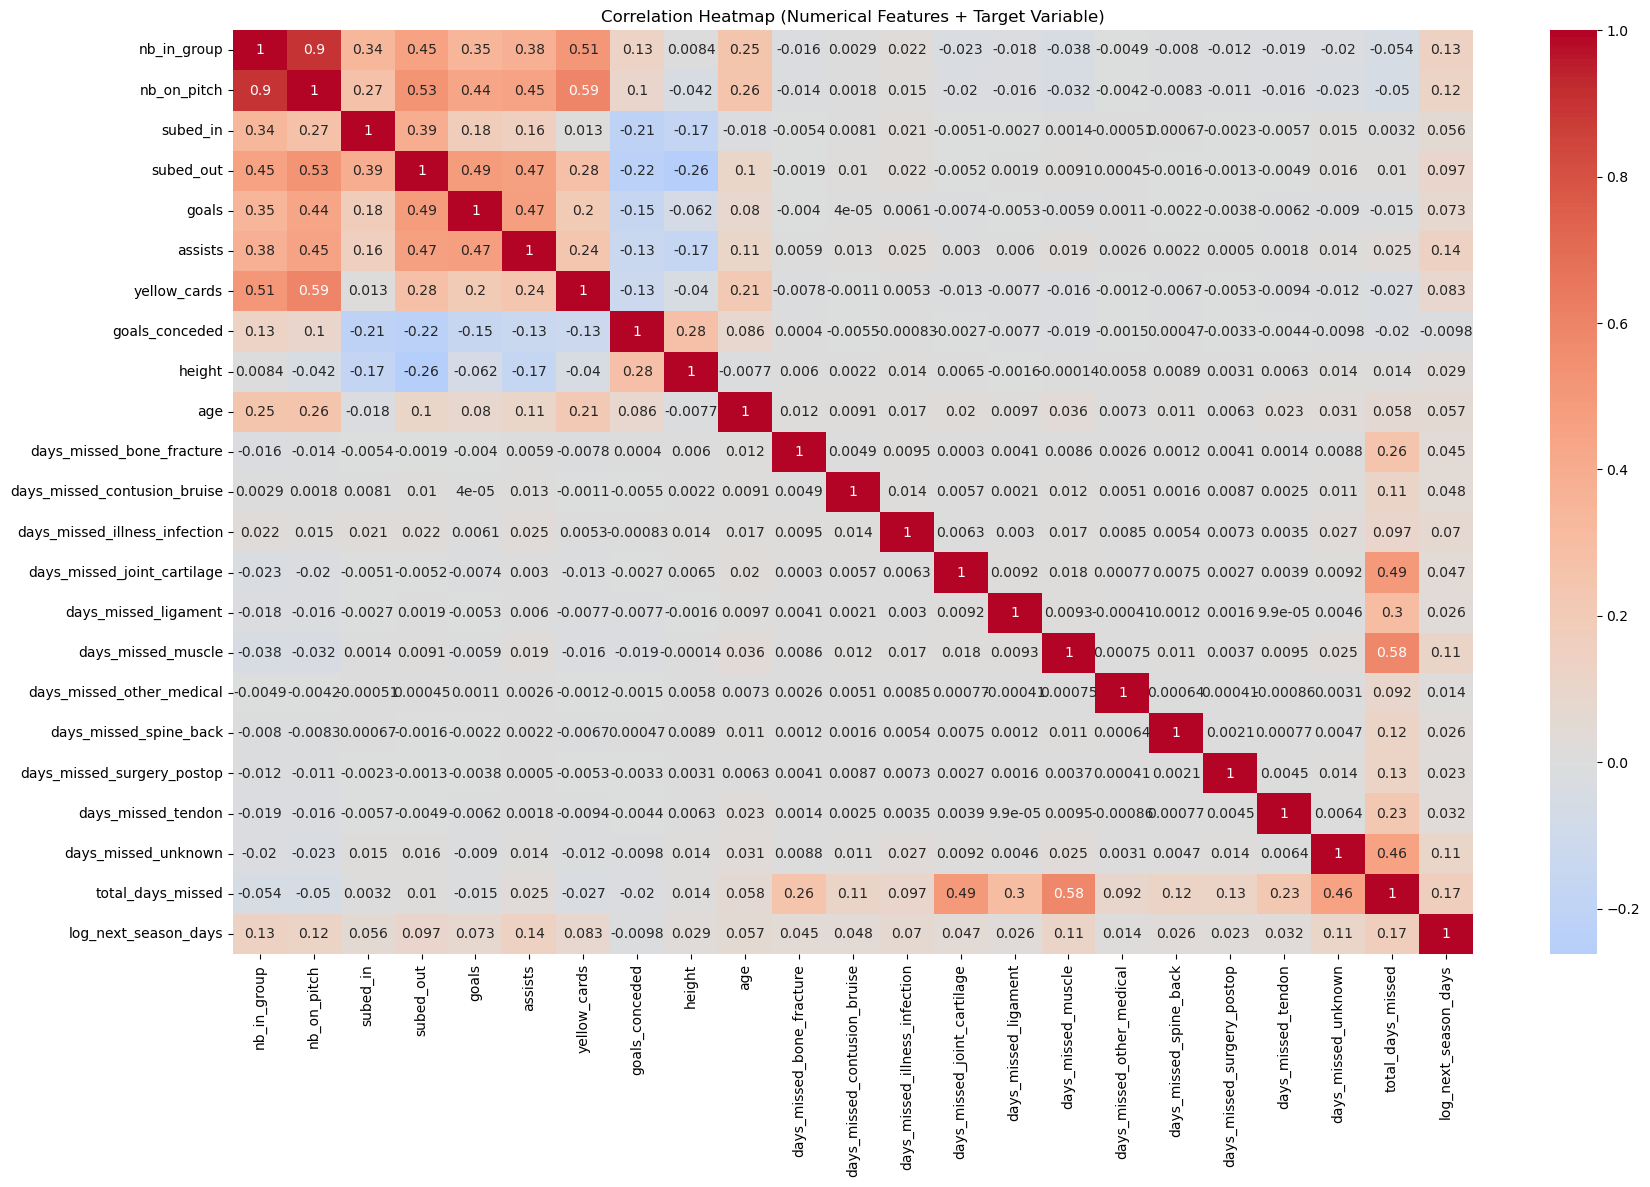

In [225]:
plt.figure(figsize=(20,12))
corr = df_clean[numeric_cols +[target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center =0)
plt.title("Correlation Heatmap (Numerical Features + Target Variable)")
plt.show()

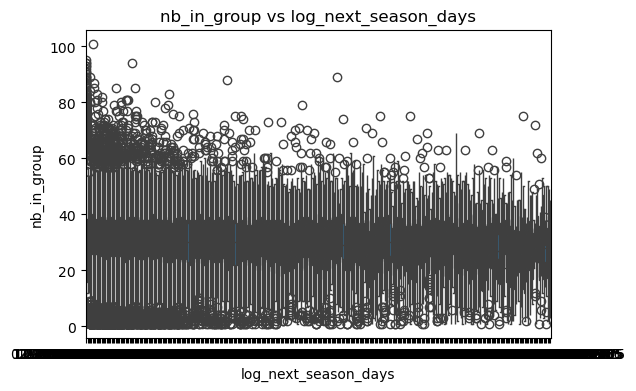

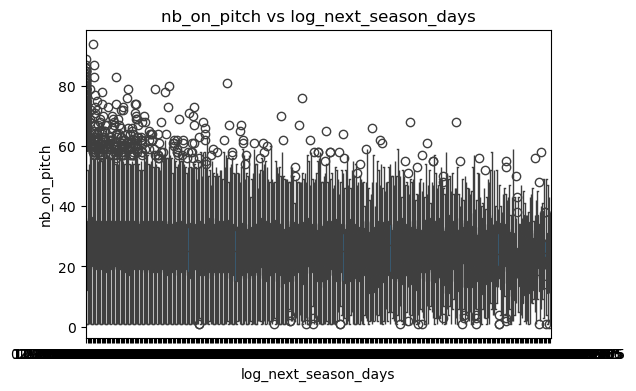

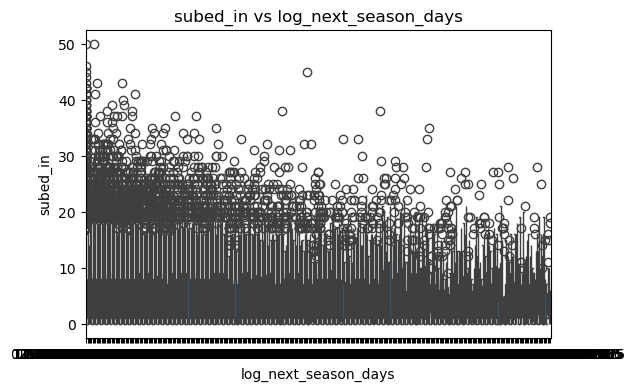

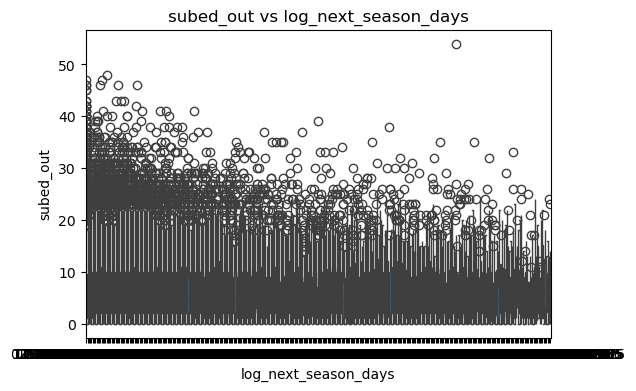

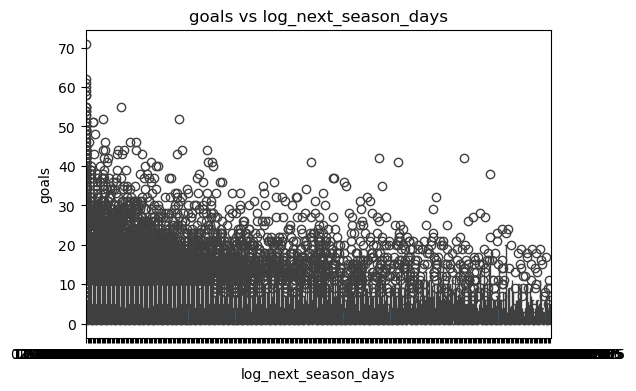

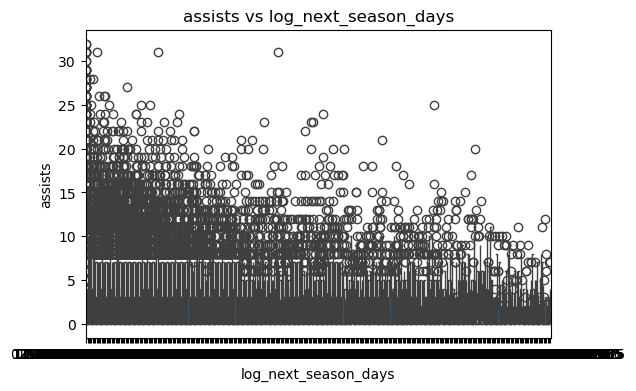

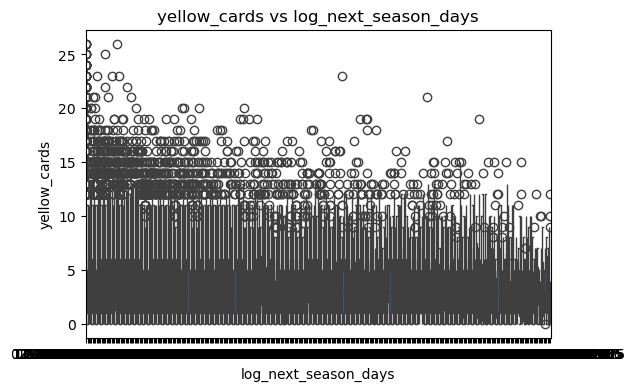

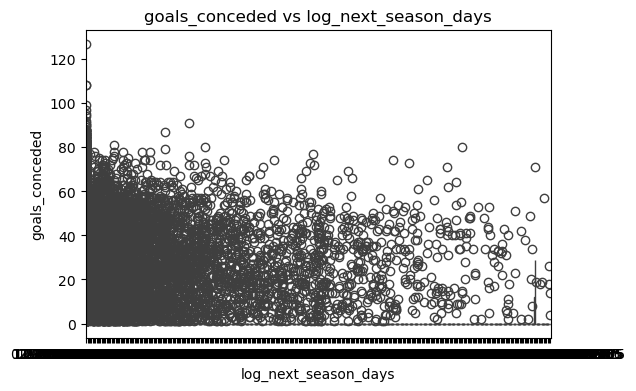

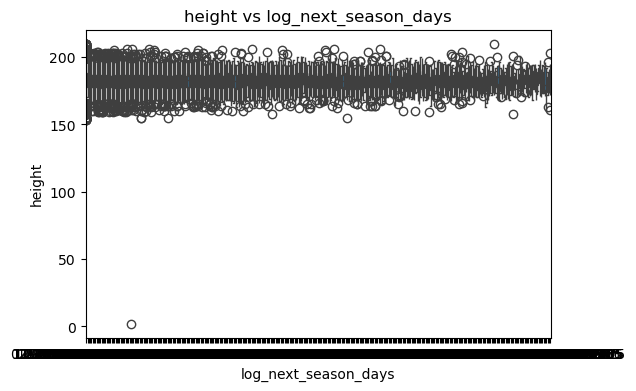

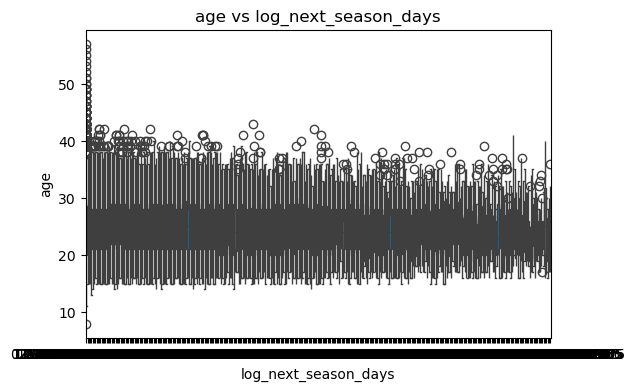

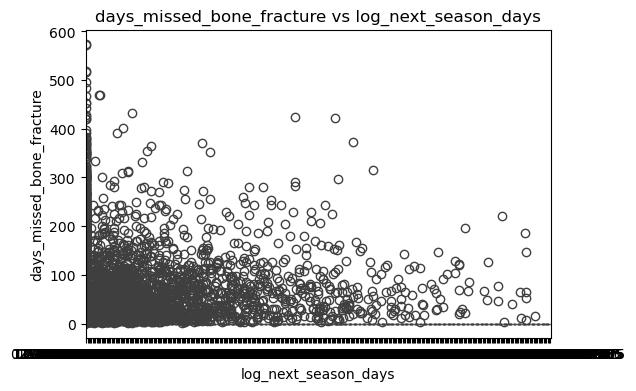

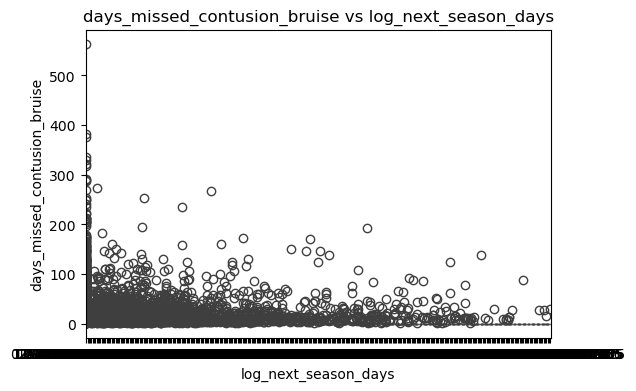

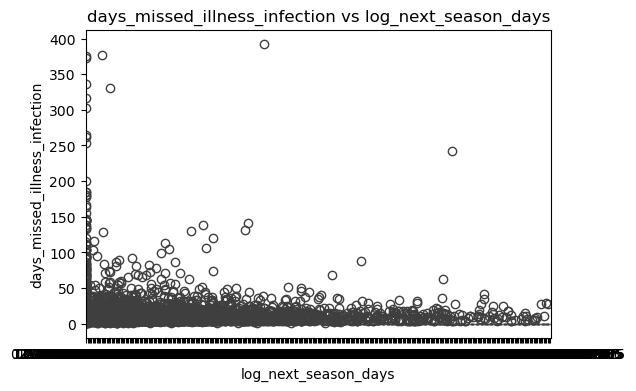

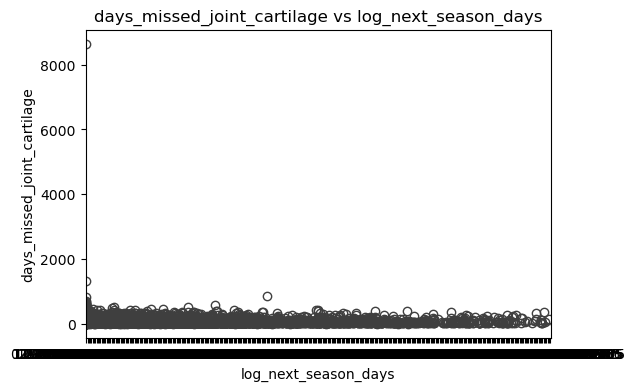

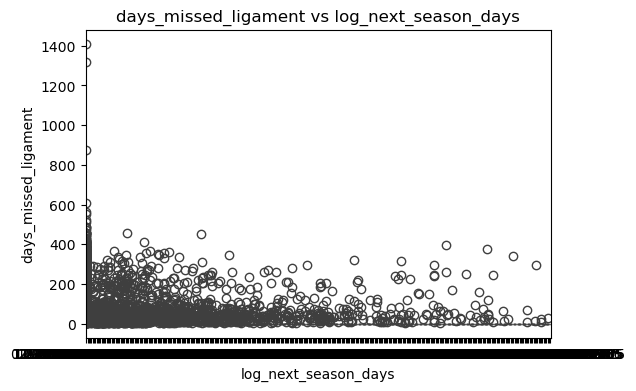

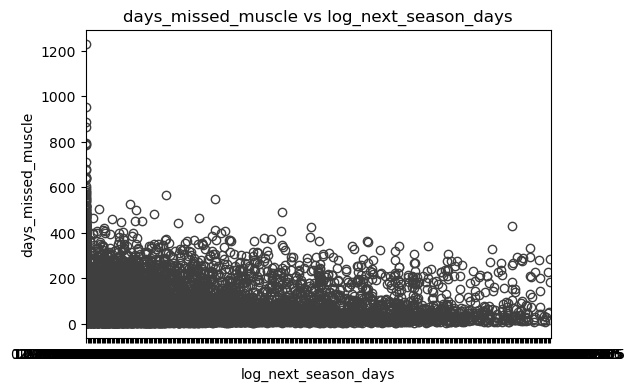

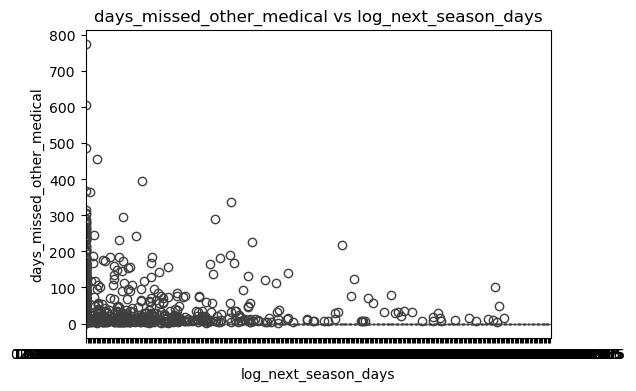

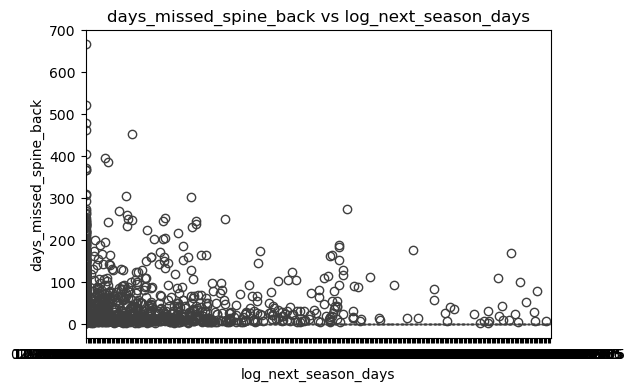

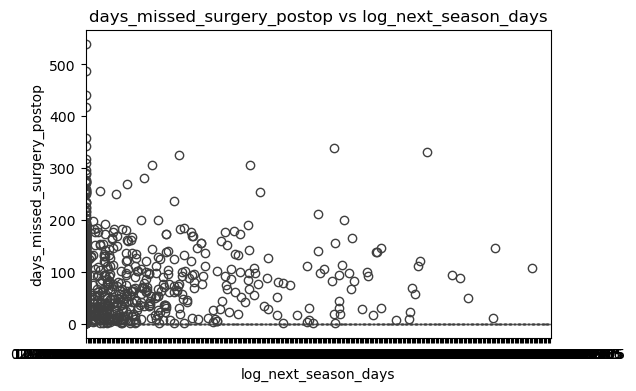

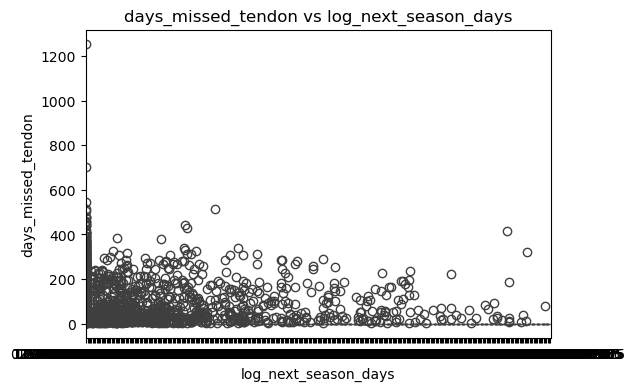

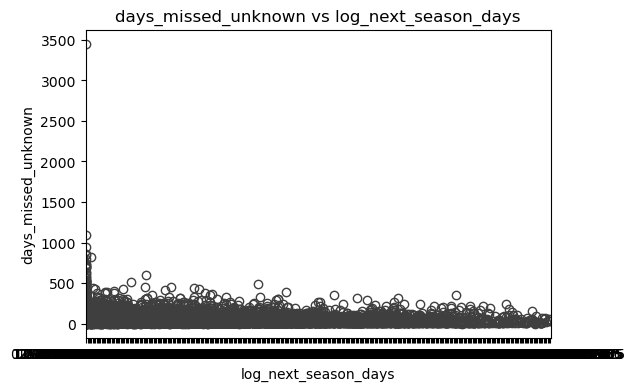

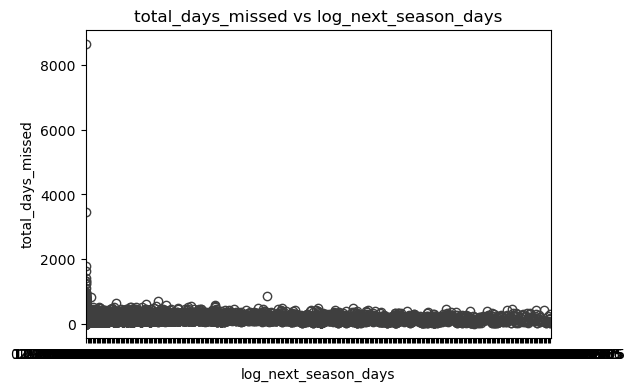

In [226]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=col, data=df_clean)
    plt.title(f"{col} vs {target}")
    plt.show()

In [227]:
corr = df_clean[numeric_cols + [target]].corr()[target].sort_values(ascending=False)
print(corr)

log_next_season_days             1.000000
total_days_missed                0.171621
assists                          0.144486
nb_in_group                      0.132353
nb_on_pitch                      0.120950
days_missed_muscle               0.113186
days_missed_unknown              0.107186
subed_out                        0.097332
yellow_cards                     0.083119
goals                            0.073404
days_missed_illness_infection    0.070055
age                              0.057121
subed_in                         0.055859
days_missed_contusion_bruise     0.047569
days_missed_joint_cartilage      0.047170
days_missed_bone_fracture        0.044562
days_missed_tendon               0.031530
height                           0.029205
days_missed_spine_back           0.026495
days_missed_ligament             0.026481
days_missed_surgery_postop       0.022630
days_missed_other_medical        0.013779
goals_conceded                  -0.009791
Name: log_next_season_days, dtype:

Past injury history is clearly the most predictive feature for future injury.

Other features like games played, substitutions, goals, etc., are weak predictors on their own.

nb_in_group and nb_on_pitch → very highly correlated (~0.9) → strong multicollinearity. We will drop one to simplify the model.

total_days_missed is highly correlated with many days_missed_* columns (as expected, since it’s their sum).

Some days_missed_* columns have moderate correlations with each other (e.g., days_missed_muscle with total_days_missed ~0.58).

In [85]:
df_clean= df_clean.drop(columns=["nb_in_group"])

#### Categorical feature

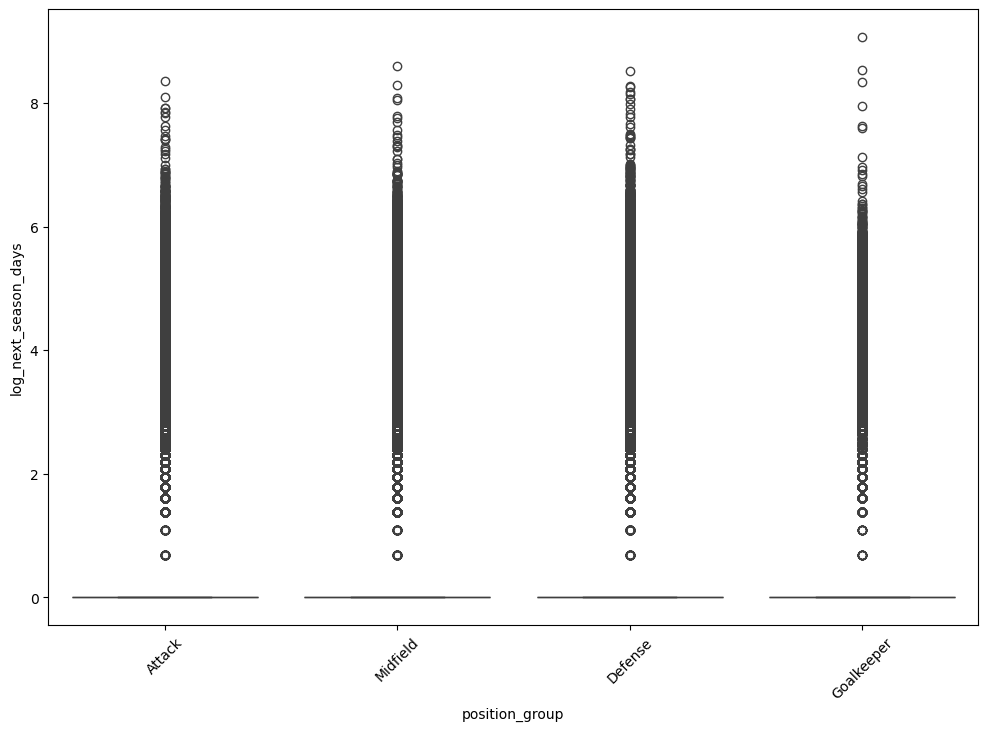

In [76]:
plt.figure(figsize=(12,8))
sns.boxplot(x='position_group', y='log_next_season_days', data=df_clean)
plt.xticks(rotation=45)  
plt.show()

In [239]:
df_clean = df_clean.drop(columns= "next_season_days")
output_folder = 'exported_data'
filename = 'full_dataset.csv'

# Create folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Full path
file_path = os.path.join(output_folder, filename)

# Export the DataFrame
df.to_csv(file_path, index=False)

print(f"Data exported to {file_path}")

Data exported to exported_data\full_dataset.csv


## Model

### Train Test Split (time-based)

In [86]:
df_clean["season_id"].value_counts().sort_index()

season_id
2000     6667
2001     7734
2002     8679
2003     9841
2004    10979
2005    11985
2006    13315
2007    14492
2008    15718
2009    17327
2010    18983
2011    20829
2012    22448
2013    23977
2014    25572
2015    27682
2016    29764
2017    32179
2018    34600
2019    36855
2020    39977
2021    42998
2022    43975
2023    43347
2024    34472
Name: count, dtype: int64

In [164]:
df_clean.head(5)

,player_id,season_id,nb_in_group,nb_on_pitch,goals,assists,subed_in,subed_out,yellow_cards,goals_conceded,...,days_missed_ligament,days_missed_muscle,days_missed_other_medical,days_missed_spine_back,days_missed_surgery_postop,days_missed_tendon,days_missed_unknown,total_days_missed,next_season_days,log_next_season_days
0,1,2000,45,28,16.0,2,5,6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2001,34,30,9.0,0,2,6,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2002,38,34,12.0,0,4,9,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2003,29,27,7.0,1,8,12,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2004,19,19,3.0,1,0,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Based on the value counts of season_id, We’ll use:

- Train: 2000–2018

- Validation: 2019–2021

- Test: 2022–2024

In [87]:
numeric_cols = [
    'nb_on_pitch',
    'subed_in',
    'subed_out',
    'goals',
    'assists',
    'yellow_cards',
    'goals_conceded',
    'height',
    'age',
    'days_missed_bone_fracture',
    'days_missed_contusion_bruise',
    'days_missed_illness_infection',
    'days_missed_joint_cartilage',
    'days_missed_ligament',
    'days_missed_muscle',
    'days_missed_other_medical',
    'days_missed_spine_back',
    'days_missed_surgery_postop',
    'days_missed_tendon',
    'days_missed_unknown',
    'total_days_missed'
]

categorical_cols = ["position_group"]

In [88]:
feature_cols = numeric_cols + categorical_cols

In [116]:
train_mask = df_clean["season_id"] <= 2018
val_mask   = (df_clean["season_id"] >= 2019) & (df_clean["season_id"] <= 2021)
test_mask  = df_clean["season_id"] >= 2022

In [117]:
df_train = df_clean[train_mask]
df_val = df_clean[val_mask]
df_test = df_clean[test_mask]

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

In [118]:
del df_train[target]
del df_val[target]
del df_test[target]

### One-hot Encoding

In [94]:
from sklearn.feature_extraction import DictVectorizer

In [95]:
dv = DictVectorizer(sparse = False)

In [119]:
train_dict = df_train[feature_cols].to_dict(orient = "records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[feature_cols].to_dict(orient = "records")
X_val = dv.transform(val_dict)

test_dict = df_test[feature_cols].to_dict(orient = "records")
X_test = dv.transform(test_dict)

### Model Training & Parameter Tuning

#### Ridge Regression

In [130]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(
    alpha=1.0,            
    fit_intercept=True,    
    copy_X=True,
    max_iter=10000,       
    tol=1e-4,
    solver='saga',      
    positive=False,      
    random_state=42    
)
ridge_model.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,10000
,tol,0.0001
,solver,'saga'
,positive,False
,random_state,42


In [131]:
y_val_pred = ridge_model.predict(X_val)

In [132]:
mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred))

spearman_corr = spearmanr(np.expm1(y_val), np.expm1(y_val_pred)).correlation

# Top-10% injury capture
k = int(0.10 * len(y_val_pred))
top_k_idx = np.argsort(y_val_pred)[-k:]
top_k_capture = (np.expm1(y_val).to_numpy()[top_k_idx] > 0).mean()

print("MAE:", mae)
print("Spearman correlation:", spearman_corr)
print("Top-10% injury capture:", top_k_capture)

MAE: 13.940960885153816
Spearman correlation: 0.31588927970858327
Top-10% injury capture: 0.5112242343319703


#### LightGBM regression

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

In [99]:
lgb_pipeline = Pipeline([
    ("reg", lgb.LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [100]:
sample_weight = np.where(y_train > 0, 5.0, 1.0)

In [121]:
lgb_pipeline.fit(
    X_train,
    y_train,
    reg__sample_weight=sample_weight,
    reg__eval_set=[(X_val, y_val)],
    reg__eval_metric="l1",
    reg__callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 352771, number of used features: 25
[LightGBM] [Info] Start training from score 1.502633


,steps,"[('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'regression'


In [122]:
# Predict log-days
y_val_pred = lgb_pipeline.predict(X_val)

C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [123]:
# MAE in original days
mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred))

# Ranking correlation
spearman_corr = spearmanr(np.expm1(y_val), np.expm1(y_val_pred)).correlation

# Top-10% injury capture
k = int(0.10 * len(y_val_pred))
top_k_idx = np.argsort(y_val_pred)[-k:]
top_k_capture = (np.expm1(y_val).to_numpy()[top_k_idx] > 0).mean()

print("MAE:", mae)
print("Spearman correlation:", spearman_corr)
print("Top-10% injury capture:", top_k_capture)


MAE: 14.990316702135592
Spearman correlation: 0.3378625944523481
Top-10% injury capture: 0.5754819327380456


In [134]:
param_options = [
    {"num_leaves": 31, "learning_rate": 0.1, "n_estimators": 100},
    {"num_leaves": 50, "learning_rate": 0.05, "n_estimators": 200},
    {"num_leaves": 20, "learning_rate": 0.2, "n_estimators": 150},
]

In [139]:
# Make y_val safe for positional indexing
y_val_array = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

best_score = float("inf")
best_params = None
best_model = None

# Manual tuning loop
for params in param_options:
    lgb_pipeline = Pipeline([
        ("reg", lgb.LGBMRegressor(
            objective="regression",
            boosting_type="gbdt",
            random_state=42,
            n_jobs=-1,
            **params
        ))
    ])
    
    lgb_pipeline.fit(
        X_train,
        y_train,
        reg__sample_weight=sample_weight,
        reg__eval_set=[(X_val, y_val)],
        reg__eval_metric="l1",
        reg__callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    y_preds = lgb_pipeline.predict(X_val)
    
    # Compute metrics on original scale if y was log-transformed
    mae = mean_absolute_error(np.expm1(y_val_array), np.expm1(y_preds))
    spearman_corr = spearmanr(np.expm1(y_val_array), np.expm1(y_preds)).correlation
    
    # Top 10% capture
    k = int(0.10 * len(y_preds))
    top_k_idx = np.argsort(y_preds)[-k:]
    top_k_capture = (np.expm1(y_val_array[top_k_idx]) > 0).mean()
    
    print(f"Params: {params}, MAE: {mae:.4f}, Spearman: {spearman_corr:.4f}, Top-10% capture: {top_k_capture:.4f}")
    
    if mae < best_score:
        best_score = mae
        best_params = params
        best_model = lgb_pipeline

print("\nBest params:", best_params)
print("Best validation MAE:", best_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 352771, number of used features: 25
[LightGBM] [Info] Start training from score 1.502633


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Params: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100}, MAE: 15.0046, Spearman: 0.3365, Top-10% capture: 0.5708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 352771, number of used features: 25
[LightGBM] [Info] Start training from score 1.502633


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Params: {'num_leaves': 50, 'learning_rate': 0.05, 'n_estimators': 200}, MAE: 14.9988, Spearman: 0.3370, Top-10% capture: 0.5703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 352771, number of used features: 25
[LightGBM] [Info] Start training from score 1.502633
Params: {'num_leaves': 20, 'learning_rate': 0.2, 'n_estimators': 150}, MAE: 15.0255, Spearman: 0.3349, Top-10% capture: 0.5587

Best params: {'num_leaves': 50, 'learning_rate': 0.05, 'n_estimators': 200}
Best validation MAE: 14.998828173056353


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


#### Neural Network

In [124]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# X already numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

# Targets
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)  # logged
y_val_tensor   = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

# Binary targets for probability of any days
y_train_bin = torch.tensor((np.expm1(y_train.to_numpy()) > 0).astype(int), dtype=torch.float32).unsqueeze(1)
y_val_bin   = torch.tensor((np.expm1(y_val.to_numpy()) > 0).astype(int), dtype=torch.float32).unsqueeze(1)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, y_train_bin), batch_size=1024, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor, y_val_bin), batch_size=1024)


In [125]:
import torch.nn as nn

class ZeroInflatedNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # head 1: probability of any days
        self.prob_head = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        # head 2: regression (log-days if >0)
        self.reg_head = nn.Linear(128, 1)
        
    def forward(self, x):
        shared_out = self.shared(x)
        prob = self.prob_head(shared_out)
        log_days_pred = self.reg_head(shared_out)
        # expected log-days = prob * log-days
        expected_log_days = prob * log_days_pred
        return prob, log_days_pred, expected_log_days


In [141]:
import torch.optim as optim

model = ZeroInflatedNN(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Binary loss + regression loss
bce_loss = nn.BCELoss()   # for probability
mae_loss = nn.L1Loss()    # for log-days


In [127]:
criterion = nn.L1Loss()  # MAE is robust to outliers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [128]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch_log, y_batch_bin in train_loader:
        optimizer.zero_grad()
        prob, log_pred, expected_log = model(X_batch)
        
        # Losses
        loss_prob = bce_loss(prob, y_batch_bin)
        # only consider regression loss for positive days
        mask = y_batch_bin > 0
        if mask.sum() > 0:
            loss_reg = mae_loss(log_pred[mask], y_batch_log[mask])
        else:
            loss_reg = 0.0
        
        loss = loss_prob + loss_reg
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.5676
Epoch 2, Loss: 1.3072
Epoch 3, Loss: 1.2885
Epoch 4, Loss: 1.2784
Epoch 5, Loss: 1.2686
Epoch 6, Loss: 1.2633
Epoch 7, Loss: 1.2547
Epoch 8, Loss: 1.2572
Epoch 9, Loss: 1.2546
Epoch 10, Loss: 1.2459


In [129]:
model.eval()
with torch.no_grad():
    prob_val, log_val_pred, expected_log_val = model(X_val_tensor)
    
# Convert back to actual days
expected_days_val = np.expm1(expected_log_val.numpy().flatten())
expected_days_val = np.clip(expected_days_val, 0, None)
mae = mean_absolute_error(np.expm1(y_val), expected_days_val)

k = int(0.10 * len(expected_days_val))
top_k_idx = np.argsort(expected_days_val)[-k:]
top_k_capture = (np.expm1(y_val) > 0).to_numpy()[top_k_idx].mean()

spearman_corr = spearmanr(np.expm1(y_val), expected_days_val).correlation

print("mae:", mae)
print("Spearman:", spearman_corr)
print("Top-10% capture:", top_k_capture)


mae: 13.74490343449866
Spearman: 0.32889263185957235
Top-10% capture: 0.5527831094049904


Hyperparameter Tuning for NN

In [144]:
best_spearman = -1
best_params = None
best_model_state = None

for params in hyperparams_options:
    lr = params["lr"]
    reg_weight = params["reg_weight"]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(10):
        model.train()
        total_loss = 0
        for X_batch, y_batch_log, y_batch_bin in train_loader:
            optimizer.zero_grad()
            prob, log_pred, expected_log = model(X_batch)
            
            # Losses
            loss_prob = bce_loss(prob, y_batch_bin)
            mask = y_batch_bin > 0
            if mask.sum() > 0:
                loss_reg = mae_loss(log_pred[mask], y_batch_log[mask])
            else:
                loss_reg = 0.0
            
            loss = loss_prob + reg_weight * loss_reg
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        prob_val, log_val_pred, expected_log_val = model(X_val_tensor)
        expected_days_val = np.expm1(expected_log_val.numpy().flatten())
        expected_days_val = np.clip(expected_days_val, 0, None)
        y_val_array = np.expm1(y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val)
        
        # Compute all metrics
        mae = mean_absolute_error(y_val_array, expected_days_val)
        spearman_corr = spearmanr(y_val_array, expected_days_val).correlation
        k = int(0.10 * len(expected_days_val))
        top_k_idx = np.argsort(expected_days_val)[-k:]
        top_k_capture = (y_val_array[top_k_idx] > 0).mean()
    
    # Print all metrics
    print(f"Params: {params}, MAE: {mae:.4f}, Spearman: {spearman_corr:.4f}, Top-10% capture: {top_k_capture:.4f}")
    
    # Save best model by Spearman
    if spearman_corr > best_spearman:
        best_spearman = spearman_corr
        best_params = params
        best_model_state = model.state_dict()

print("Best params:", best_params)
print("Best Spearman:", best_spearman)


Params: {'lr': 0.001, 'reg_weight': 1.0}, MAE: 13.7139, Spearman: 0.3325, Top-10% capture: 0.5625
Params: {'lr': 0.003, 'reg_weight': 1.0}, MAE: 13.7423, Spearman: 0.3262, Top-10% capture: 0.5282
Params: {'lr': 0.003, 'reg_weight': 2.0}, MAE: 13.7824, Spearman: 0.3220, Top-10% capture: 0.5130
Best params: {'lr': 0.001, 'reg_weight': 1.0}
Best Spearman: 0.33248874752158164


#### Model Selection

| Model | MAE ↓   | Spearman ↑ | Top-10% capture ↑ |
| ----- | ------- | ---------- | ----------------- |
| LGBM  | 14.9988 | 0.3370     | 0.5703            |
| Ridge | 13.9409 | 0.3159     | 0.5112            |
| NN    | 13.7139| 0.3325     | 0.5625          |

Conclusion:
- We evaluated Ridge Regression, a neural network, and LightGBM using temporal validation by season.
- Ridge and NN are slightly better at minimizing MAE overall.
- LGBM ranks predictions slightly better (0.3370) → better at ordering high vs low targets. NN is close (0.3325), Ridge is lower (0.3159).
- LGBM and NN both do well (~0.57 and 0.5625) → good at identifying top-risk cases. Ridge is lower (0.5112) → less effective at catching the top 10% of cases.

#### Train LightGBM with best params and full train set

In [176]:
Best_params: {'num_leaves': 50, 
              'learning_rate': 0.05, 
              'n_estimators': 200}

In [177]:
# Rewritten LGBM pipeline with best params
lgb_pipeline = Pipeline([
    ("reg", lgb.LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        num_leaves=50,
        learning_rate=0.05,
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=6
    ))
])

In [178]:
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

In [179]:
# Convert to dict for DictVectorizer
full_train_dict = df_full_train[feature_cols].to_dict(orient="records")
X_full_train = dv.transform(full_train_dict)

In [180]:
sample_weight = np.where(y_full_train > 0, 5.0, 1.0)

In [181]:
lgb_pipeline.fit(
    X_full_train,
    y_full_train,
    reg__sample_weight=sample_weight,
    reg__eval_set=[(X_test, y_test)],
    reg__eval_metric="l1",
    reg__callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2424
[LightGBM] [Info] Number of data points in the train set: 472601, number of used features: 25
[LightGBM] [Info] Start training from score 1.678437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,steps,"[('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,boosting_type,'gbdt'
,num_leaves,50
,max_depth,6
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'regression'


In [182]:
y_test_pred = lgb_pipeline.predict(X_test)

C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [183]:
# MAE in original days
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))

# Ranking correlation
spearman_corr = spearmanr(np.expm1(y_test), np.expm1(y_test_pred)).correlation

# Top-10% injury capture
k = int(0.10 * len(y_test_pred))
top_k_idx = np.argsort(y_test_pred)[-k:]
top_k_capture = (np.expm1(y_test).to_numpy()[top_k_idx] > 0).mean()

print("MAE:", mae)
print("Spearman correlation:", spearman_corr)
print("Top-10% injury capture:", top_k_capture)


MAE: 13.186145885358956
Spearman correlation: 0.2845146209026889
Top-10% injury capture: 0.43238361113391904


#### Train NN with full train dataset

In [193]:
X_train_tensor = torch.tensor(X_full_train, dtype=torch.float32)

y_train_log = torch.tensor(
    y_full_train.to_numpy(),
    dtype=torch.float32
).unsqueeze(1)

y_train_bin = torch.tensor(
    (np.expm1(y_full_train.to_numpy()) > 0).astype(np.float32)
).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_test_log = torch.tensor(
    y_test.to_numpy(),
    dtype=torch.float32
).unsqueeze(1)

y_test_bin = torch.tensor(
    (np.expm1(y_test.to_numpy()) > 0).astype(np.float32)
).unsqueeze(1)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_log, y_train_bin),
    batch_size=1024,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_log, y_test_bin),
    batch_size=1024
)


In [185]:
lr = 0.001
reg_weight = 1.0
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [194]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch_log, y_batch_bin in train_loader:
        optimizer.zero_grad()

        prob, log_pred, expected_log = model(X_batch)

        # Classification loss
        loss_prob = bce_loss(prob, y_batch_bin)

        # Regression loss only for positive cases
        mask = (y_batch_bin > 0).squeeze(1)

        if mask.any():
            loss_reg = mae_loss(log_pred[mask], y_batch_log[mask])
        else:
            loss_reg = torch.zeros(1, device=X_batch.device)

        loss = loss_prob + reg_weight * loss_reg
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 1.2254
Epoch 2/10, Loss: 1.2247
Epoch 3/10, Loss: 1.2241
Epoch 4/10, Loss: 1.2239
Epoch 5/10, Loss: 1.2232
Epoch 6/10, Loss: 1.2236
Epoch 7/10, Loss: 1.2231
Epoch 8/10, Loss: 1.2232
Epoch 9/10, Loss: 1.2227
Epoch 10/10, Loss: 1.2233


In [195]:
model.eval()
with torch.no_grad():
    prob_val, log_val_pred, expected_log_val = model(X_val_tensor)
    
# Convert back to actual days
expected_days_val = np.expm1(expected_log_val.numpy().flatten())
expected_days_val = np.clip(expected_days_val, 0, None)
mae = mean_absolute_error(np.expm1(y_val), expected_days_val)

k = int(0.10 * len(expected_days_val))
top_k_idx = np.argsort(expected_days_val)[-k:]
top_k_capture = (np.expm1(y_val) > 0).to_numpy()[top_k_idx].mean()

spearman_corr = spearmanr(np.expm1(y_val), expected_days_val).correlation

print("mae:", mae)
print("Spearman:", spearman_corr)
print("Top-10% capture:", top_k_capture)


mae: 13.770615571278304
Spearman: 0.33116304897153803
Top-10% capture: 0.5516147876157891


#### Final Comparison

| Model                 | MAE ↓     | Spearman ↑       | Top-10% capture ↑ |
| --------------------- | --------- | ---------------- | ----------------- |
| **LGBM (full train)** | **↑13.18**     | **↓ ~0.28–0.30** | **↓ ~0.43**       |
| **NN (full train)**   | **13.77** | **0.331**        | **0.552**         |

When trained on the same full data, the NN generalizes better than LGBM.

### Export & Load Model (NN)

In [240]:
import pickle

In [231]:
FILENAME = "nn_pipeline.pkl"

# Save
with open(FILENAME, "wb") as f:
    pickle.dump({
        "vectorizer": dv,
        "model_state": model.state_dict(),
        "input_dim": X_full_train.shape[1],
        "hidden_dim": 128,
        "reg_weight": 1.0,
        "feature_order": feature_cols
    }, f)

print("Full NN pipeline saved successfully!")


Full NN pipeline saved successfully!


In [233]:

# Load
with open(FILENAME, "rb") as f:
    artifacts = pickle.load(f)

dv = artifacts["vectorizer"]
feature_order = artifacts["feature_order"]
input_dim = artifacts["input_dim"]

# Rebuild NN
model_test = ZeroInflatedNN(input_dim=input_dim)  # just pass input_dim
model_test.load_state_dict(artifacts["model_state"])
model_test.eval()

ZeroInflatedNN(
  (shared): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (prob_head): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (reg_head): Linear(in_features=128, out_features=1, bias=True)
)

In [200]:
def risk_label(days):
    if days <= 1:
        return "No risk"
    elif days <= 7:
        return "Low"
    elif days <= 21:
        return "Medium"
    elif days <= 60:
        return "High"
    else:
        return "Severe"

In [237]:
def predict_player(player_dict):
    # Fill missing features with 0 for numeric, leave categorical as-is
    input_dict = {f: player_dict.get(f, 0) for f in feature_order}

    # Transform using vectorizer (handles numeric + categorical)
    X_vec = dv.transform([input_dict])
    X_tensor = torch.tensor(X_vec, dtype=torch.float32)

    # NN prediction
    with torch.no_grad():
        _, _, expected_log_days = model(X_tensor)
    predicted_days = np.expm1(expected_log_days.numpy().flatten())[0]
    predicted_risk = risk_label(predicted_days)
    return predicted_days, predicted_risk

In [242]:
sample_player = {
    # Numeric features
    'nb_on_pitch': 8,
    'subed_in': 5,
    'subed_out': 3,
    'goals': 7,
    'assists': 4,
    'yellow_cards': 2,
    'goals_conceded': 12,
    'height': 192,  # cm
    'age': 24,
    'days_missed_bone_fracture': 0,
    'days_missed_contusion_bruise': 0,
    'days_missed_illness_infection': 0,
    'days_missed_joint_cartilage': 0,
    'days_missed_ligament': 7,
    'days_missed_muscle': 0,
    'days_missed_other_medical': 0,
    'days_missed_spine_back': 0,
    'days_missed_surgery_postop': 3,
    'days_missed_tendon': 0,
    'days_missed_unknown': 0,
    'total_days_missed':10,
    
    # Categorical features
    'position_group': 'Striker'
}


In [243]:
predict_player(sample_player)

(np.float32(3.1416636), 'Low')